In [3]:
# HIDDEN

from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [33]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def mean_squared_error(table, x, y):
    def for_line(slope, intercept):
        fitted = (slope * table.column(x) + intercept)
        return np.average((table.column(y) - fitted) ** 2)
    return for_line

def residual_plot(table, x, y):
    fitted = fit(table, x, y)
    residuals = table.column(y) - fitted
    res_table = Table().with_columns([
            'fitted', fitted, 
            'residuals', residuals])
    res_table.scatter(0, 1, fit_line=True)

Now that we have explored ways to use multiple features to predict a categorical variable, it is natural to study ways of using multiple predictor variables to predict a quantitative variable. A commonly used method to do this is called *multiple regression*.

We will start with an example to review some fundamental aspects of *simple* regression, that is, regression based on one predictor variable.

### Example: Simple Regression

Suppose that our goal is to use regression to estimate the height of a basset hound based on its weight, using a sample that looks consistent with the regression model. Suppose the observed correlation $r$ is 0.5, and that the summary statistics for the two variables are as in the table below: 

|       |**average**    |**SD**     |   
|------:|:-------------:|:---------:|
|height |14 inches      |2 inches   |
|weight |50 pounds      |5 pounds   |

To calculate the equation of the regression line, we need the slope and the intercept.

$$
\mbox{slope} ~=~ \frac{r \cdot \mbox{SD of }y}{\mbox{SD of }x} ~=~
\frac{0.5 \cdot 2 \mbox{ inches}}{5 \mbox{ pounds}} ~=~ 0.2 ~\mbox{inches per pound}
$$


$$
\mbox{intercept} ~=~ \mbox{average of }y - \mbox{slope}\cdot \mbox{average of } x
~=~ 14 \mbox{ inches} ~-~ 0.2 \mbox{ inches per pound} \cdot 50 \mbox{ pounds}
~=~ 4 \mbox{ inches}
$$

The equation of the regression line allows us to calculate the estimated height, in inches,
based on a given weight in pounds:

$$
\mbox{estimated height} ~=~ 0.2 \cdot \mbox{given weight} ~+~ 4
$$

The slope of the line is measures the increase in the estimated height per unit increase in weight. The slope is positive, and it is important to note that this does not mean that we think basset hounds get taller if they put on weight. The slope reflects the difference in the average heights of two groups of dogs that are 1 pound apart in weight. Specifically, consider a group of dogs whose weight is $w$ pounds, and the group whose weight is $w+1$ pounds. The second group is estimated to be 0.2 inches taller, on average. This is true for all values of $w$ in the sample.

In general, the slope of the regression line can be interpreted as the average increase in $y$ per unit increase in $x$. Note that if the slope is negative, then for every unit increase in $x$, the average of $y$ decreases.

### Multiple Predictors

In multiple regression, more than one predictor variable is used to estimate $y$. For example, a Dartmouth study of undergraduates collected information about their use of an online course forum and their GPA. We might want to predict a student's GPA based on the number of days that they visit the course forum and how many times they answer someone else's question.  Then the multiple regression model would involve two slopes, an intercept, and random errors as before:

GPA $~=~ \mbox{slope}_d * \mbox{days} ~+~ \mbox{slope}_a * \mbox{answers} ~+~ \mbox{intercept} ~+~ \mbox{random error}$

Our goal would be to find the estimated GPA using the best estimates of the two slopes and the intercept; as before, the "best" estimates are those that minimize the mean squared error of estimation.

To start off, we will investigate the data set, which is [described online](http://studentlife.cs.dartmouth.edu/). Each row represents a student. In addition to the student's GPA, the row tallies 

* `days online`: The number of days on which the student viewed the online forum
* `views`: The number of posts viewed
* `contributions`: The number of contributions, including posts and follow-up discussions
* `questions`: The number of questions posted
* `notes`: The number of notes posted
* `answers`: The number of answers posted

In [26]:
grades = Table.read_table('grades_and_piazza.csv')
grades

GPA,days online,views,contributions,questions,notes,answers
2.863,29,299,5,1,1,0
3.505,57,299,0,0,0,0
3.029,27,101,1,1,0,0
3.679,67,301,1,0,0,0
3.474,43,201,12,1,0,0
3.705,67,308,45,22,0,5
3.806,36,171,20,4,3,4
3.667,82,300,26,11,0,3
3.245,44,127,6,1,1,0
3.293,35,259,16,13,1,0


### Correlation Matrix

Perhaps we wish to predict GPA based on forum usage. A natural first step is to see which variables are correlated with the GPA. Here is the correlation matrix. The `to_df` method generates a [Pandas](http://pandas.pydata.org/) dataframe containing the same data as the table, and its `corr` method generates a matrix of correlations for each pair of columns.

All forum usage variables are correlated with GPA, but the `notes` correlation has a very small magnitude.

In [27]:
grades.to_df().corr()

,GPA,days online,views,contributions,questions,notes,answers
GPA,1.000000,0.684905,0.444175,0.427897,0.409212,-0.160604,0.440382
days online,0.684905,1.000000,0.654557,0.448319,0.435269,-0.230839,0.502810
views,0.444175,0.654557,1.000000,0.426406,0.361002,0.065627,0.365010
contributions,0.427897,0.448319,0.426406,1.000000,0.857981,0.295661,0.702679
questions,0.409212,0.435269,0.361002,0.857981,1.000000,-0.006365,0.515661
notes,-0.160604,-0.230839,0.065627,0.295661,-0.006365,1.000000,0.229599
answers,0.440382,0.502810,0.365010,0.702679,0.515661,0.229599,1.000000


To start off, let us perform the simple regression of `GPA` on just `days online`, the count with the strongest correlation with an `r` of 0.68. Here is the scatter diagram and regression line.

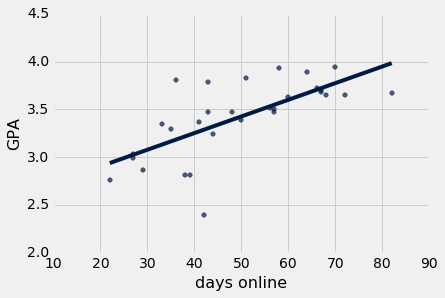

In [28]:
grades.scatter('days online', 'GPA', fit_line=True)

We can immediately see that the relation is not entirely linear, and a residual plot highlights this fact. One issue is that the GPA is never above 4.0, so the model assumption that `y` values are bell shaped does not hold in this case. 

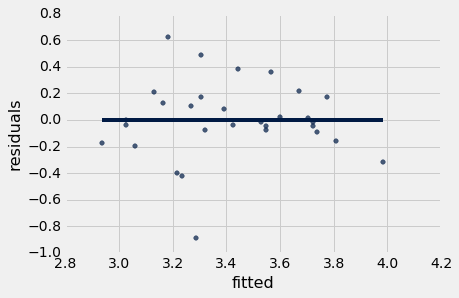

In [34]:
residual_plot(grades, 'days online', 'GPA')

Nonetheless, the regression line does capture some of the patter in the data, and so we will continue to work with it, noting that our predictions may not be entirely justified by the regression model.

The root mean squared error is a bit above 1/4 of a GPA point when predicting GPA from only the days online.

In [38]:
grades_days_mse = mean_squared_error(grades, 'days online', 'GPA')
a, b = minimize(grades_days_mse)
grades_days_mse(a, b) ** 0.5

0.28494512878662448

### Two Predictors

Perhaps more information can improve our prediction. The number of `answers` is also correlated with GPA. When using it alone as a predictor, the root mean squared error is greater because the correlation has lower magnitude than `days online`.

In [40]:
grades_answers_mse = mean_squared_error(grades, 'answers', 'GPA')
a, b = minimize(grades_answers_mse)
grades_answers_mse(a, b) ** 0.5

0.35110518920562062

However, the two variables can be used together. First, we define the mean squared error in terms of a line that has two slopes, one for each variable, as well as an intercept.

In [52]:
def grades_days_answers_mse(a_days, a_answers, b):
    fitted = a_days * grades.column('days online') + \
             a_answers * grades.column('answers') + \
             b
    y = grades.column('GPA')
    return np.average((y - fitted) ** 2)

minimize(grades_days_answers_mse)

array([ 0.0157683,  0.0301254,  2.6031789])

The `minimize` function returns three values, the slope for `days online`, the slope for `answers`, and the intercept. Together, these three values describe a linear prediction function. For example, someone who spent 50 days online and answered 5 questions is predicted to have a GPA of about 3.54. 

In [53]:
np.round(0.0157683 * 50 + 0.0301254 * 5 + 2.6031789, 2)

3.54

The root mean squared error of this predictor is a bit smaller than that of either single-variable predictor we had before!

In [54]:
a_days, a_answers, b = minimize(grades_days_answers_mse)
grades_days_answers_mse(a_days, a_answers, b) ** 0.5

0.28161529539241298

### Combining all variables

We can combine all information about the course forum in order to attempt to find an even better predictor.

In [72]:
def fit_grades(a_days, a_views, a_contributions, a_questions, a_notes, a_answers, b):
    return a_days * grades.column('days online') + \
           a_views * grades.column('views') + \
           a_contributions * grades.column('contributions') + \
           a_questions * grades.column('questions') + \
           a_notes * grades.column('notes') + \
           a_answers * grades.column('answers') + \
           b

def grades_all_mse(a_days, a_views, a_contributions, a_questions, a_notes, a_answers, b):
    fitted = fit_grades(a_days, a_views, a_contributions, a_questions, a_notes, a_answers, b)
    y = grades.column('GPA')
    return np.average((y - fitted) ** 2)

minimize(grades_all_mse)

array([  1.43703000e-02,  -8.15000000e-05,   6.50720000e-03,
        -1.72780000e-03,  -4.04014000e-02,   1.59645000e-02,
         2.65375470e+00])

Using all of this information, we have constructed a predictor with an even smaller root mean squared error. The `*` below passes all of the return values of the `minimize` function as arguments to `grades_all_mse`.

In [66]:
grades_all_mse(*minimize(grades_all_mse)) ** 0.5

0.27783237243108722

All of this information did not improve our predictor very much. The root mean squared error decreased from 2.82 for the best single-variable predictor to 2.78 when using all of the available information. 

**Definition of $R^2$, consistent with our old $r^2$**

When we studied simple regression, we had noted that 

$$
|r| ~=~ \frac{\mbox{SD of fitted values of }y}{\mbox{SD of observed values of } y}
$$

Let us use our old functions to compute the fitted values and confirm that this is true for our example:

In [63]:
fitted = fit(grades, 'days online', 'GPA')
np.std(fitted) / np.std(grades.column('GPA'))

0.68490480299828194

Because variance is the square of the standard deviation, we can say that

$$
0.469 ~=~r^2 ~=~ \frac{\mbox{variance of fitted values of }y}{\mbox{variance of observed values of }y}
$$

Notice that this way of thinking about $r^2$ involves only the estimated values and the observed values, *not the number of predictor variables*. Therefore, it motivates the definition of *multiple $R^2$*:

$$
R^2 ~=~ \frac{\mbox{variance of fitted values of }y}{\mbox{variance of observed values of }y}
$$

It is a fact of mathematics that this quantity is always between 0 and 1. With multiple predictor variables, there is no clear interpretation of a sign attached to the square root of $R^2$. Some of the predictors might be positively associated with $y$, others negatively. An overall measure of the fit is provided by $R^2$. 

In [70]:
fitted = fit_grades(*minimize(grades_all_mse))
np.var(fitted) / np.var(grades.column('GPA'))

0.49525855565521787

It is not always wise to maximize $R^2$ by including many variables, but we will address this concern later in the text.

We can also view the residual plot of multiple regression, just as before. The horizontal axis shows fitted values and the vertical axis shows errors. Again, there is some structure to this plot, so perhaps the relation between these variables is not entirely linear. In this case, the structure is minor enough that the regression model is a reasonable choice of predictor.

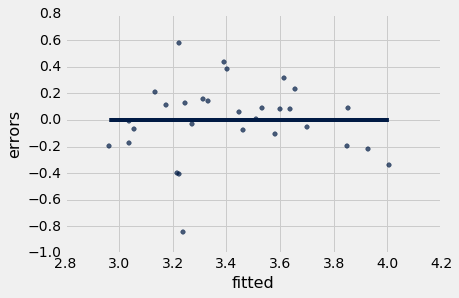

In [71]:
Table().with_columns([
        'fitted', fitted,
        'errors', grades.column('GPA') - fitted
    ]).scatter(0, 1, fit_line=True)